Same exercise as exercise FDM-8, but now with implicit method

# Ex11.9

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
import time

In [6]:
Lx=100e3             #m
Ly=80e3              #m
kappa=1e-6
Q_=0                 #Q/ρCp
Tmax =100            #delta
T0 =200 +273.15      #celcius -> K
sigma=1e4            #m

In [7]:
nnx=11       #np.random.randint()  aka amount of nodes on x-axis, not leaps
nny=9         #np.random.randint()  aka amount of nodes on y-axis, not leaps
nnp=nnx*nny
hx=Lx/(nnx-1)
hy=Ly/(nny-1)

In [8]:
nnt=100
dt=(0.5*min(hx**2, hy**2)/kappa)*27.5/300

In [9]:
#meshgrid
xcoords=np.tile(np.arange(-Lx/2, Lx/2 + hx/2, hx), nny)
ycoords=np.repeat(np.arange(-Ly/2, Ly/2 + hy/2, hy), nnx)

In [10]:
def analytic_T_value(x_a, y_a, t_a, T0_a, Tmax_a, kappa_a, sigma_a):
  return T0_a + Tmax_a * np.exp(-(x_a**2 + y_a**2)/(sigma_a**2 + 4*t_a*kappa_a)) / (1 + 4*t_a*kappa_a/(sigma_a**2))

Latex(data=r'T(x,y,t)=T_0 + \frac{T_{max}}{1 + 4t\kappa/\sigma^2} e^{- \frac{x^2 + y^2}{\sigma^2 + 4t\kappa}}')

<IPython.core.display.Latex object>

In [11]:
Tref=np.zeros((nnp))

for k in range(nnp):
  Tref[k]=analytic_T_value(xcoords[k], ycoords[k], dt*nnt, T0, Tmax, kappa, sigma)

In [12]:
Tinitial=np.copy(Tref)          #analytic T at t=0 with end boundaries
for k in range(nnx, nnp-nnx):
  if k%nnx and (k+1)%nnx:
    Tinitial[k]=T0 + Tmax * np.exp(-(xcoords[k]**2 + ycoords[k]**2)/(sigma**2))

# implicit

In [13]:
def implicit_2D_matrix_creator(kappa_imp_M, dt_imp_M, hx_imp_M, hy_imp_M, nnx_imp_M, nny_imp_M):
  sx, sy = kappa_imp_M*dt_imp_M/(hx_imp_M**2), kappa_imp_M*dt_imp_M/(hy_imp_M**2)
  matrix_imp_M=np.eye(nnx_imp_M*nny_imp_M)

  for k in range(nnx_imp_M, nnx_imp_M*nny_imp_M-nnx_imp_M):
    if k%nnx_imp_M and (k+1)%nnx_imp_M:
      matrix_imp_M[k][k]=(1 + 2*sx + 2*sy)
      matrix_imp_M[k][k-1], matrix_imp_M[k][k+1]=-sx, -sx
      matrix_imp_M[k][k-nnx_imp_M], matrix_imp_M[k][k+nnx_imp_M]=-sy, -sy

  return matrix_imp_M

Text(0.5, 1.0, 'Trial version of output matrix')

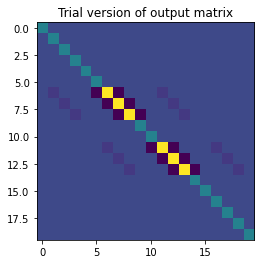

In [14]:
plt.imshow(implicit_2D_matrix_creator(1,1,1,2,5,4))
plt.title('Trial version of output matrix')

In [15]:
def b_vector_imp(Told_imp_b, T0_imp_b, Q__imp_b, dt_imp_b, nnx_imp_b, nny_imp_b):
  Tnew_imp_b=np.ones((nnx_imp_b*nny_imp_b))*T0_imp_b

  for k in range(nnx_imp_b, nnx_imp_b*nny_imp_b-nnx_imp_b):
    if k%nnx_imp_b and (k+1)%nnx_imp_b:
      Tnew_imp_b[k]=Told_imp_b[k] + Q__imp_b*dt_imp_b

  return Tnew_imp_b

In [16]:
time1=time.time()
M_imp_inv=np.linalg.inv(implicit_2D_matrix_creator(kappa, dt, hx, hy, nnx, nny))
time3=time.time()
Told_imp=np.copy(Tinitial)
storage_imp, Tmax_list=[(Told_imp-273.15).reshape((nny,nnx))], [max(Tinitial-273.15)]
storage_tosave=[Told_imp]

for _ in range(nnt):
  Told_mod=b_vector_imp(Told_imp, T0, Q_, dt, nnx, nny)
  Tnew_imp=np.dot(M_imp_inv, Told_mod)
  Told_imp=Tnew_imp
  
  Tmax_list.append(max(Tnew_imp-273.15))
  storage_imp.append((Told_imp-273.15).reshape((nny,nnx)))
  storage_tosave.append(Told_imp-273.15)
time2=time.time()

print(f'''Time required for FDM implicit if nnt={nnt} time steps and nnp={nnp} and dt x{round(dt / (0.5*min(hx**2, hy**2)/kappa), 4)}:
total is {round(time2-time1,3)} seconds,
where for a matrix creation the time is {round(time3-time1,3)} seconds 
and for looping over time {round(time2-time3,3)} seconds.''')

Time required for FDM implicit if nnt=100 time steps and nnp=99 and dt x0.0917:
total is 0.019 seconds,
where for a matrix creation the time is 0.008 seconds 
and for looping over time 0.012 seconds.


In [17]:
#let's write our data to .csv file to compare that with fem
data = np.copy(storage_tosave)

np.savetxt('fdm diffusion implicit.csv', data, delimiter=',')

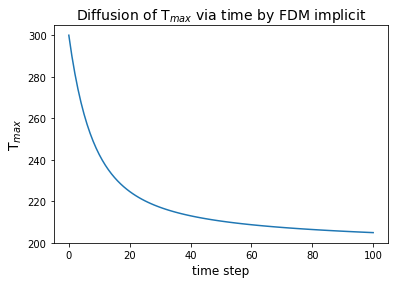

In [18]:
plt.plot(range(nnt+1), Tmax_list)
plt.title(r'Diffusion of T$_{max}$ via time by FDM implicit', fontsize=14)
plt.xlabel('time step', fontsize=12)
plt.ylabel(r'T$_{max}$', fontsize=14)
plt.ylim(bottom=200)

#plt.savefig('2d fdm implicit diffusion Tmax evo.pdf')
#plt.savefig('2d fdm implicit diffusion Tmax evo.png', transparent=True, dpi=600)
plt.show()

# warning: potentially time-consuming! comparison of different dt

In [19]:
dt1=(0.5*min(hx**2, hy**2)/kappa)*500
dt2=(0.5*min(hx**2, hy**2)/kappa)*50
dt3=(0.5*min(hx**2, hy**2)/kappa)*5
dt4=(0.5*min(hx**2, hy**2)/kappa)*0.5

In [20]:
storage_Tmax=[]
dt_storage= sorted([dt1, dt2, dt3, dt4])[::-1]

for i in dt_storage:
  #ref
  Tref_trial=np.zeros((nnp))
  for k in range(nnp):
    Tref_trial[k] = analytic_T_value(xcoords[k], ycoords[k], nnt*i, T0, Tmax, kappa, sigma)

  #initial
  Tinitial_trial=np.copy(Tref_trial)
  for k in range(nnx, nnp-nnx):
    if k%nnx and (k+1)%nnx:
      Tinitial_trial[k] = T0 + Tmax * np.exp(-(xcoords[k]**2 + ycoords[k]**2)/(sigma**2))

  #looping over time
  M_imp_inv_trial=np.linalg.inv(implicit_2D_matrix_creator(kappa, i, hx, hy, nnx, nny))
  Told_imp_trial=np.copy(Tinitial_trial)
  storage_trial=[max(Told_imp_trial -273.15)]

  for _ in range(nnt):
    Told_mod_trial=b_vector_imp(Told_imp_trial, T0, Q_, i, nnx, nny)
    Tnew_imp_trial=np.dot(M_imp_inv_trial, Told_mod_trial)
    Told_imp_trial=Tnew_imp_trial
    storage_trial.append(max(Tnew_imp_trial-273.15))
  
  #save
  storage_Tmax.append(storage_trial)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


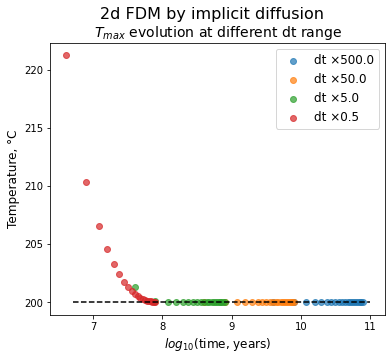

In [21]:
fig, (ax1) = plt.subplots(1,1, figsize=(6,5))
fig.suptitle('2d FDM by implicit diffusion', fontsize=16)

for i in range(len(storage_Tmax)):
  if max(storage_Tmax[i]) > 401:
    k=i
    staik=dt_storage[i]/(0.5*min(hx**2, hy**2)/kappa)
    plt.figtext(0.1, -0.1*(i), 
                f'*dt×{round(staik, 3)} leads to explosion if nnp={nnp}', 
                fontsize=12)
  else: 
    staik=round(dt_storage[i]/(0.5*min(hx**2, hy**2)/kappa),2)
    ax1.scatter(np.log10(np.arange(nnt+1)[0::5]*dt_storage[i]/3600/24/365.25), 
                storage_Tmax[i][0::5], alpha=0.7, label=f'dt ×{staik}')

ax1.set_title(r'$T_{max}$ evolution at different dt range', fontsize=14)
ax1.set_xlabel('$log_{10}$(time, years)', fontsize=12)
ax1.set_ylabel('Temperature, °C', fontsize=12)
ax1.legend(fontsize=12)
ax1.plot(np.linspace(6.7, 11, ((nnt+1)//5 +1)), [200]*((nnt+1)//5 +1), '--', color='k')

# plt.savefig('2d fdm implicit dif dt Tmax evo.pdf')
# plt.savefig('2d fdm implicit dif dt Tmax evo.png', transparent=True, dpi=600)
plt.show()

# pics

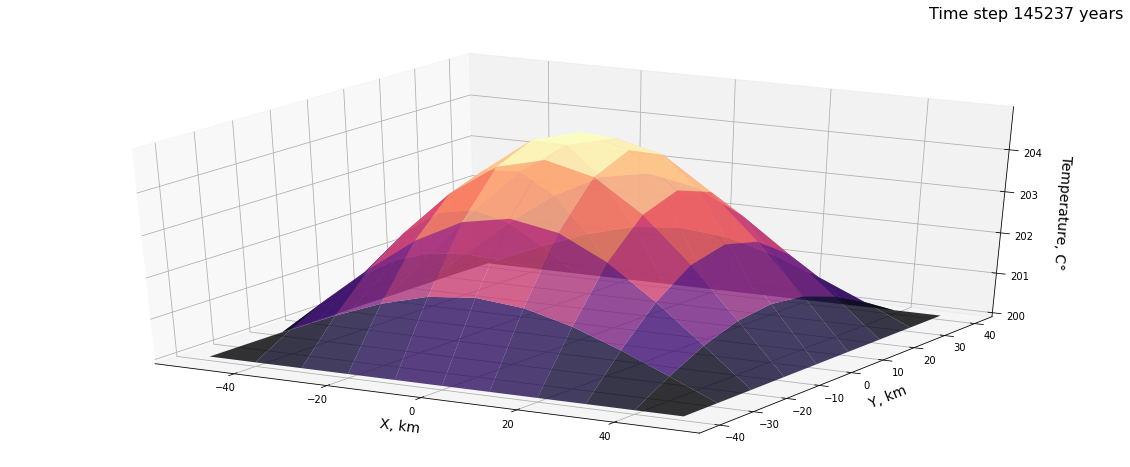

In [22]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')   #Tinitial.reshape((nny,nnx))

ax.plot_surface(xcoords.reshape((nny,nnx))/1e3, ycoords.reshape((nny,nnx))/1e3, 
                storage_imp[-1], cmap = 'magma', alpha=0.8) # color = 'darkseagreen'

ax.set_xlabel('\nX, km', fontsize=14, rotation=-10)
ax.set_ylabel('\nY, km', fontsize=14, rotation=10)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Temperature, C°\n', fontsize=14, rotation=266)
plt.title('Time step %.2d years' %(dt/3600/24/365.25), loc='right', fontsize=16)
plt.grid()

#plt.savefig('Time-error correclation.pdf')
#plt.savefig('Time-error correclation.png', transparent=True, dpi=600)
plt.show()

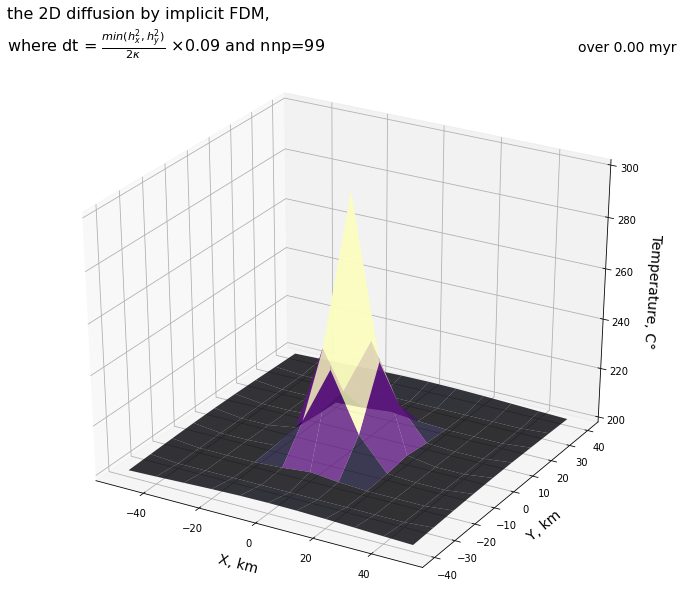

In [26]:
def update_plot(frame_number, zarray, plot):
  plot[0].remove()
  plot[0] = ax.plot_surface(x, y, zarray[frame_number], cmap="magma", alpha=0.8)
  ax.set_title("over %.2f myr" % (frame_number*dt/3600/24/365.25/1e6), 
               loc='right', fontsize=14)
  ax.set_zlim(200, 300)

fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('\nX, km', fontsize=14, rotation=-10)
ax.set_ylabel('\nY, km', fontsize=14, rotation=10)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Temperature, C°\n', fontsize=14, rotation=266)
ax.set_zlim(200, 300)

ax.set_title("the 2D diffusion by implicit FDM,\n" + 
             r'where dt = $\frac{min(h^2_x, h^2_y)}{2\kappa}$ ' + 
             f'×{round(dt/(0.5*min(hx**2, hy**2)/kappa),2)} and nnp={nnp}', 
             loc='left', fontsize=16)

N = 14
nmax = nnt
x, y = xcoords.reshape((nny, nnx))/1e3, ycoords.reshape((nny, nnx))/1e3

plot = [ax.plot_surface(x, y, storage_imp[0], color='0.75', rstride=1, cstride=1)]


animate = animation.FuncAnimation(fig, update_plot, nmax, interval=40, fargs=(storage_imp, plot))
#animate.save('matplot009.gif', writer="imagemagick")
f = r"2D diffusion by implicit.gif"
writergif = animation.PillowWriter()#fps=60
animate.save(f, writer=writergif)
plt.show()

In [24]:
fig = go.Figure(
    data=[go.Surface(z=storage_imp[0])],
    layout=go.Layout(updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None])])]),
    frames=[go.Frame(data=[go.Surface(z=k)], name=str(i)) for i, k in enumerate(storage_imp)]
)

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="tomato", project_z=True), colorscale='magma')

fig.update_layout(title='data HEATPILES', autosize=False, width=650, height=500, margin=dict(l=0, r=0, b=0, t=0))

def frame_args(duration):
    return {"frame": {"duration": duration}, "mode": "immediate", "fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}

sliders = [{"pad": {"b": 10, "t": 60}, "len": 0.9, "x": 0.1, "y": 0, "steps": [{"args": [[f.name], frame_args(0)], "label": str(k), "method": "animate", } for k, f in enumerate(fig.frames)], }]
    
fig.update_layout(sliders=sliders)

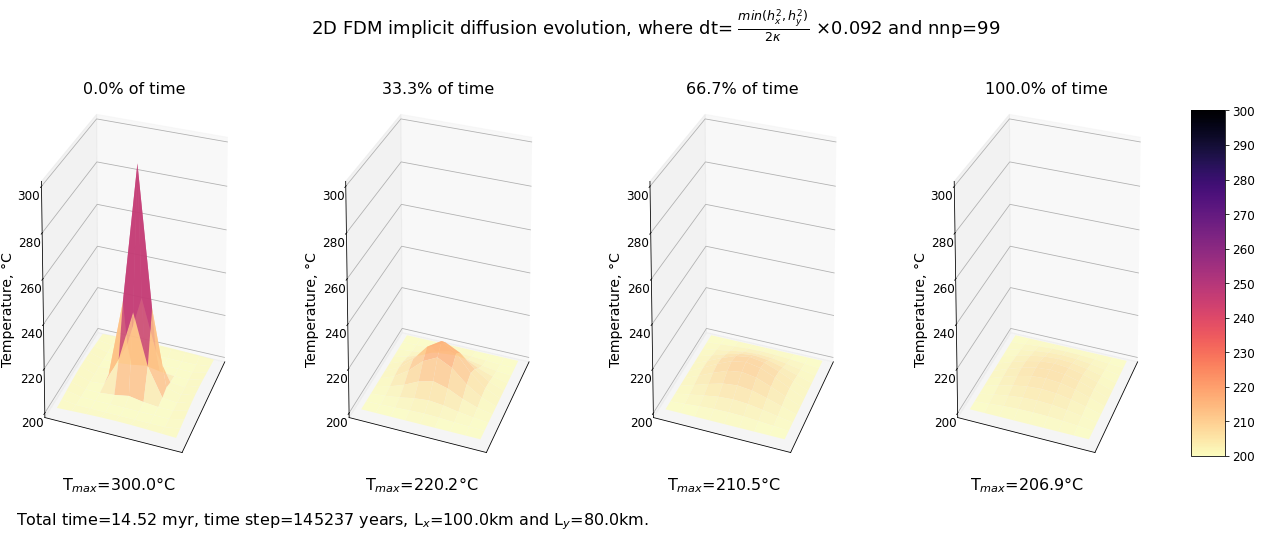

In [25]:
from matplotlib.cm import ScalarMappable
staik=dt/(0.5*min(hx**2, hy**2)/kappa)
fig = plt.figure(figsize=(24,8))
fig.suptitle('2D FDM implicit diffusion evolution, ' + 
             r'where dt= $\frac{min(h^2_x, h^2_y)}{2\kappa}$' +
             f' ×{round(staik, 3)} and nnp={nnp}', #⋅ $\frac{1}{30}$' 
             fontsize=18)

for i in range(4):
  ax = fig.add_subplot(1, 4, i+1, projection='3d')
  surf = ax.plot_surface(xcoords.reshape((nny,nnx)), ycoords.reshape((nny,nnx)), 
                         storage_imp[(nnt*i)//4].reshape((nny,nnx)), 
                         cmap='magma_r', alpha=0.8, vmin=200, vmax=300)
  ax.set_zlim(200, 300)
  ax.view_init(20,200)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'{round(i*100/3,1)}% of time', fontsize=16)
  ax.zaxis.set_rotate_label(False)
  ax.set_zlabel("Temperature, °C\n", fontsize=14, rotation=90)
  ax.set_zticklabels(range(200,301,20), size=12)
  #ax.grid(False)
  #ax.set_zticks([])
  #ax.axis('off')
  #fig.colorbar(surf)
  plt.figtext(0.19 + i*0.175, 0.15, 
              r'T$_{max}$' + f"={round(Tmax_list[(nnt*i)//4],1)}°C", 
              ha="center", va="center", fontsize=16)
  if not i:
    plt.figtext(0.13, 0.08, f'Total time={round(dt*nnt/3600/24/365.25/1e6,2)} myr, ' +
                f'time step={round(dt/3600/24/365.25)} years, ' + r'L$_x$=' + 
                f'{Lx/1e3}km and ' + r'L$_y$=' + f'{Ly/1e3}km.', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
cbar = fig.colorbar(ScalarMappable(norm=surf.norm, cmap=surf.cmap), shrink=0.85,
                    ticks=range(200, 300+5, 10), cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)

#plt.axis('off')

# plt.savefig('implicit fdm diffusion evo dt.pdf')
# plt.savefig('implicit fdm diffusion evo dt.png', transparent=True, dpi=600)
plt.show()